# Movielens 영화 추천 실습

In [1]:
import numpy as np
import scipy
import implicit

print(np.__version__)
print(scipy.__version__)
print(implicit.__version__)

1.21.4
1.7.1
0.4.8


# 1. 데이터 준비와 전처리


이전 스텝에서 배운 MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작해 보겠습니다.

이번에 활용할 데이터셋은 추천 시스템의 MNIST라고 부를만한 Movielens 데이터입니다.

- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
- 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.
- 별점을 시청횟수로 해석해서 생각하겠습니다.
- 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.


Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다.

In [2]:
import os
import pandas as pd
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [4]:
# 별점횟수를 시청횟수로 하겠다고 가정했기때문에 
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [5]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [6]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# users
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/users.dat'
users = pd.read_csv(movie_file_path, sep='::', engine='python', encoding='ISO-8859-1')
users.head()

,1,F,1.1,10,48067
0,2,M,56,16,70072
1,3,M,25,15,55117
2,4,M,45,7,02460
3,5,M,25,20,55455
4,6,F,50,9,55117


In [8]:
cols = ['user_id','gender','age','occupation','zipcode']
users = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
users.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# 2) EDA

In [9]:
# ratings :user_id 유니크갯수
ratings['user_id'].nunique()  # movie:user_id 6040

6039

In [10]:
# ratings :movie_id 유니크갯수
ratings['movie_id'].nunique()  # movie:movie_id 3883

3628

In [11]:
# users :user_id 유니크갯수
users['user_id'].nunique()   

6040

In [12]:
# users :age 유니크갯수
users['age'].nunique()  

7

In [13]:
# users :occupation 유니크갯수
users['occupation'].nunique()

21

In [14]:
# movies : movie_id 유니크
movies['movie_id'].nunique()

3883

In [15]:
# movies : title 유니크
movies['title'].nunique()

3883

In [16]:
# movies : genre 유니크
movies['genre'].nunique()

301

In [17]:
# 3개 데이터셋 1개로 합치기
ratings_movies = pd.merge(ratings,movies, how='outer',on='movie_id')
ratings_movies

,user_id,movie_id,counts,timestamp,title,genre
0,1.0,1193,5.0,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama
1,2.0,1193,5.0,978298413.0,One Flew Over the Cuckoo's Nest (1975),Drama
2,12.0,1193,4.0,978220179.0,One Flew Over the Cuckoo's Nest (1975),Drama
3,15.0,1193,4.0,978199279.0,One Flew Over the Cuckoo's Nest (1975),Drama
4,17.0,1193,5.0,978158471.0,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
836728,NaN,3829,NaN,NaN,Mad About Mambo (2000),Comedy|Romance
836729,NaN,3856,NaN,NaN,Autumn Heart (1999),Drama
836730,NaN,3891,NaN,NaN,Turn It Up (2000),Crime|Drama
836731,NaN,3904,NaN,NaN,"Uninvited Guest, An (2000)",Drama


In [18]:
import copy
df = pd.merge(ratings_movies,users, how='outer',on='user_id')
df = df.drop(['timestamp','zipcode'],axis=1)
df

,user_id,movie_id,counts,title,genre,gender,age,occupation
0,1.0,1193.0,5.0,One Flew Over the Cuckoo's Nest (1975),Drama,F,1.0,10.0
1,1.0,661.0,3.0,James and the Giant Peach (1996),Animation|Children's|Musical,F,1.0,10.0
2,1.0,914.0,3.0,My Fair Lady (1964),Musical|Romance,F,1.0,10.0
3,1.0,3408.0,4.0,Erin Brockovich (2000),Drama,F,1.0,10.0
4,1.0,2355.0,5.0,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1.0,10.0
...,...,...,...,...,...,...,...,...
836729,NaN,3856.0,NaN,Autumn Heart (1999),Drama,NaN,NaN,NaN
836730,NaN,3891.0,NaN,Turn It Up (2000),Crime|Drama,NaN,NaN,NaN
836731,NaN,3904.0,NaN,"Uninvited Guest, An (2000)",Drama,NaN,NaN,NaN
836732,NaN,3907.0,NaN,"Prince of Central Park, The (1999)",Drama,NaN,NaN,NaN


In [19]:
# 가장 인기 있는 영화 30개(user_id로 카운트한 것)
pop_movies = df.groupby('title')['user_id'].count().sort_values(ascending=False).reset_index()
pop_movies.head(30)

,title,user_id
0,American Beauty (1999),3211
1,Star Wars: Episode IV - A New Hope (1977),2910
2,Star Wars: Episode V - The Empire Strikes Back...,2885
3,Star Wars: Episode VI - Return of the Jedi (1983),2716
4,Saving Private Ryan (1998),2561
5,Terminator 2: Judgment Day (1991),2509
6,"Silence of the Lambs, The (1991)",2498
7,Raiders of the Lost Ark (1981),2473
8,Back to the Future (1985),2460
9,"Matrix, The (1999)",2434


In [20]:
# 가장 시청이 많이된 영화 (시청누적 횟수순)
pop_movies1 = df.groupby('title')['counts'].sum().sort_values(ascending=False).reset_index()
pop_movies1.head(30)

,title,counts
0,American Beauty (1999),14449.0
1,Star Wars: Episode IV - A New Hope (1977),13178.0
2,Star Wars: Episode V - The Empire Strikes Back...,12648.0
3,Saving Private Ryan (1998),11348.0
4,Star Wars: Episode VI - Return of the Jedi (1983),11303.0
5,Raiders of the Lost Ark (1981),11179.0
6,"Silence of the Lambs, The (1991)",11096.0
7,"Matrix, The (1999)",10903.0
8,"Sixth Sense, The (1999)",10703.0
9,Terminator 2: Judgment Day (1991),10513.0


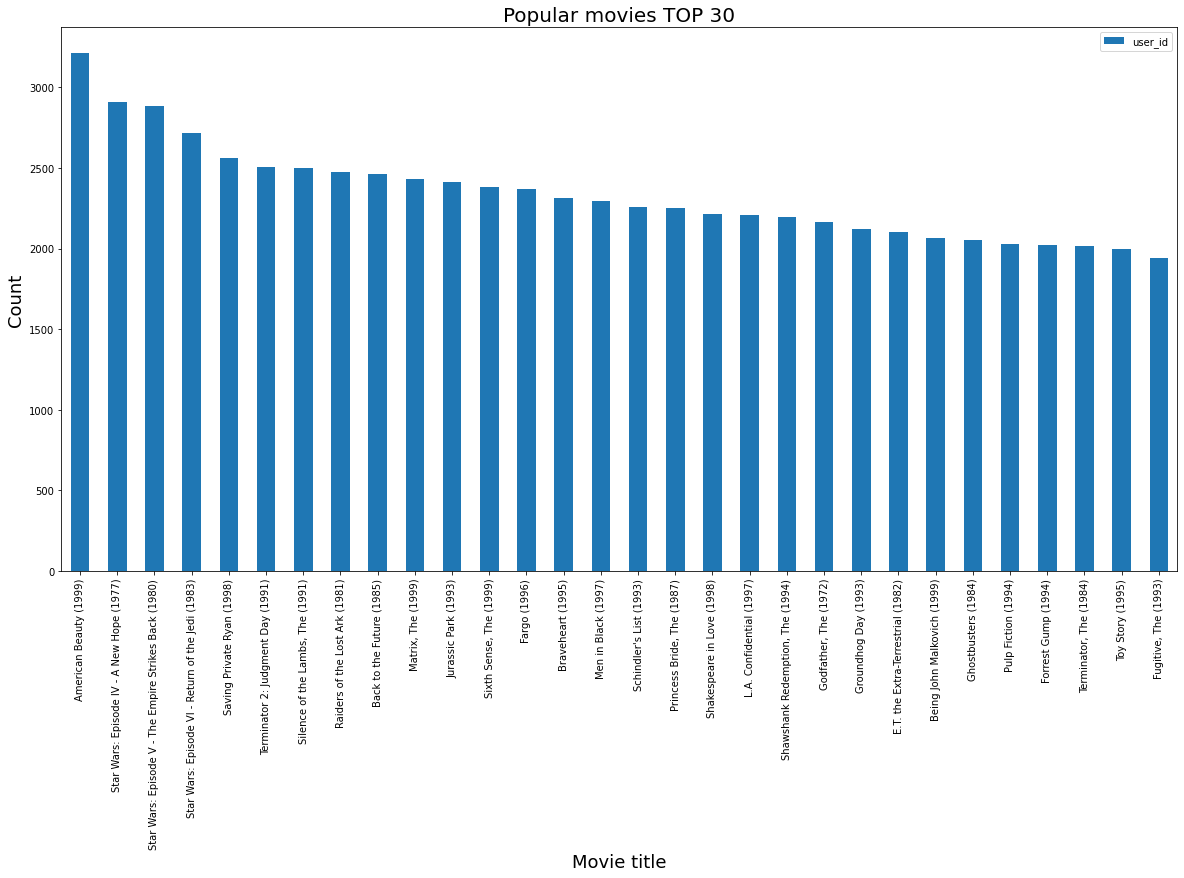

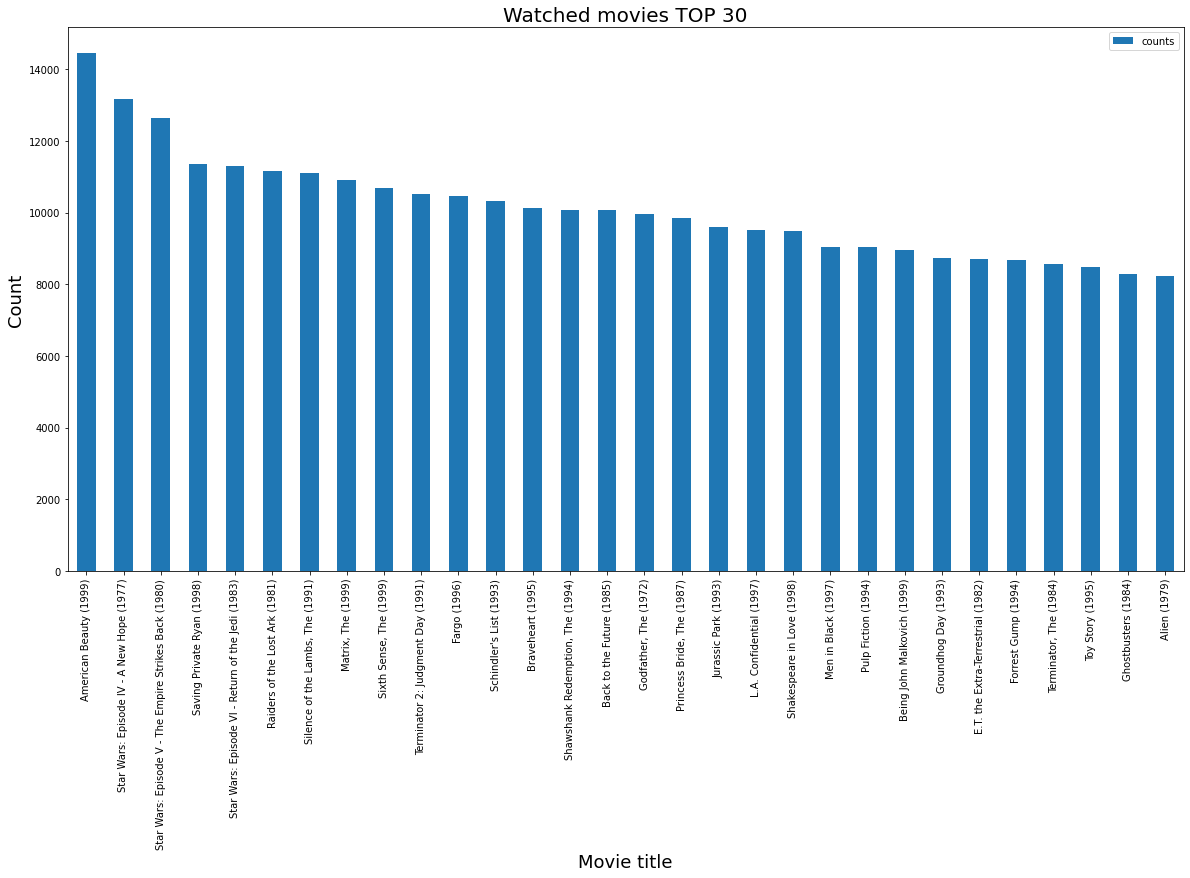

In [21]:
# 인기영화 30개 시각화
import matplotlib.pyplot as plt
pop_movies_1=pop_movies[:30]
pop_movies1_1=pop_movies1[:30]


pop_movies_1.plot.bar(x='title', figsize=(20,10))
plt.title('Popular movies TOP 30', fontsize=20)
plt.xlabel('Movie title', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()
print('='*50)
pop_movies1_1.plot.bar(x='title', figsize=(20,10))
plt.title('Watched movies TOP 30', fontsize=20)
plt.xlabel('Movie title', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()

### 인기투표한 영화순위와 시청횟수를 기준으로한 영화순위는 다르다.  
(Starwars 4편이 양들의 침묵보다 인기순위는 높았으나, 시청횟수 기준으로는 양들의 침묵이 순위가 더 높다. Raiders와 Matrix도 시청횟수로는 기존보다 순위가 높아졌다.)

# 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.

In [22]:
my_movies = ['Matrix, The (1999)','Sixth Sense, The (1999)','Jurassic Park (1993)','Men in Black (1997)','Forrest Gump (1994)']
df.columns

Index(['user_id', 'movie_id', 'counts', 'title', 'genre', 'gender', 'age',
       'occupation'],
      dtype='object')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836734 entries, 0 to 836733
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     836479 non-null  float64
 1   movie_id    836733 non-null  float64
 2   counts      836478 non-null  float64
 3   title       836733 non-null  object 
 4   genre       836733 non-null  object 
 5   gender      836479 non-null  object 
 6   age         836479 non-null  float64
 7   occupation  836479 non-null  float64
dtypes: float64(5), object(3)
memory usage: 57.5+ MB


In [24]:
for i in my_movies:
    df2=pd.DataFrame(df.loc[df['title']==i][:1])
    fd_movie_id,fd_genre = df2.movie_id,df2.genre
    print(fd_movie_id,fd_genre)
my_movies

131    2571.0
Name: movie_id, dtype: float64 131    Action|Sci-Fi|Thriller
Name: genre, dtype: object
38    2762.0
Name: movie_id, dtype: float64 38    Thriller
Name: genre, dtype: object
114    480.0
Name: movie_id, dtype: float64 114    Action|Adventure|Sci-Fi
Name: genre, dtype: object
400    1580.0
Name: movie_id, dtype: float64 400    Action|Adventure|Comedy|Sci-Fi
Name: genre, dtype: object
167    356.0
Name: movie_id, dtype: float64 167    Comedy|Romance|War
Name: genre, dtype: object


['Matrix, The (1999)',
 'Sixth Sense, The (1999)',
 'Jurassic Park (1993)',
 'Men in Black (1997)',
 'Forrest Gump (1994)']

In [25]:
df2 = pd.DataFrame({
    'user_id' : [9999]*5,
    'movie_id' : [2571.0,2762.0,480.0,1580.0,1.0],
    'counts' : [5]*5,
    'title' : my_movies,
    'genre' : ['Action|Sci-Fi|Thriller','Thriller','Action|Adventure|Sci-Fi','Action|Adventure|Comedy|Sci-Fi','Comedy|Romance|War'],
    'gender':['F','F','F','F','F'],
    'age':[25]*5,
    'occupation':[0]*5
    
})
df=pd.concat([df2,df])
df

,user_id,movie_id,counts,title,genre,gender,age,occupation
0,9999.0,2571.0,5.0,"Matrix, The (1999)",Action|Sci-Fi|Thriller,F,25.0,0.0
1,9999.0,2762.0,5.0,"Sixth Sense, The (1999)",Thriller,F,25.0,0.0
2,9999.0,480.0,5.0,Jurassic Park (1993),Action|Adventure|Sci-Fi,F,25.0,0.0
3,9999.0,1580.0,5.0,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,F,25.0,0.0
4,9999.0,1.0,5.0,Forrest Gump (1994),Comedy|Romance|War,F,25.0,0.0
...,...,...,...,...,...,...,...,...
836729,NaN,3856.0,NaN,Autumn Heart (1999),Drama,NaN,NaN,NaN
836730,NaN,3891.0,NaN,Turn It Up (2000),Crime|Drama,NaN,NaN,NaN
836731,NaN,3904.0,NaN,"Uninvited Guest, An (2000)",Drama,NaN,NaN,NaN
836732,NaN,3907.0,NaN,"Prince of Central Park, The (1999)",Drama,NaN,NaN,NaN


# preprocessing

### 결측치 제거

In [26]:
df.isnull().sum()

user_id       255
movie_id        1
counts        256
title           1
genre           1
gender        255
age           255
occupation    255
dtype: int64

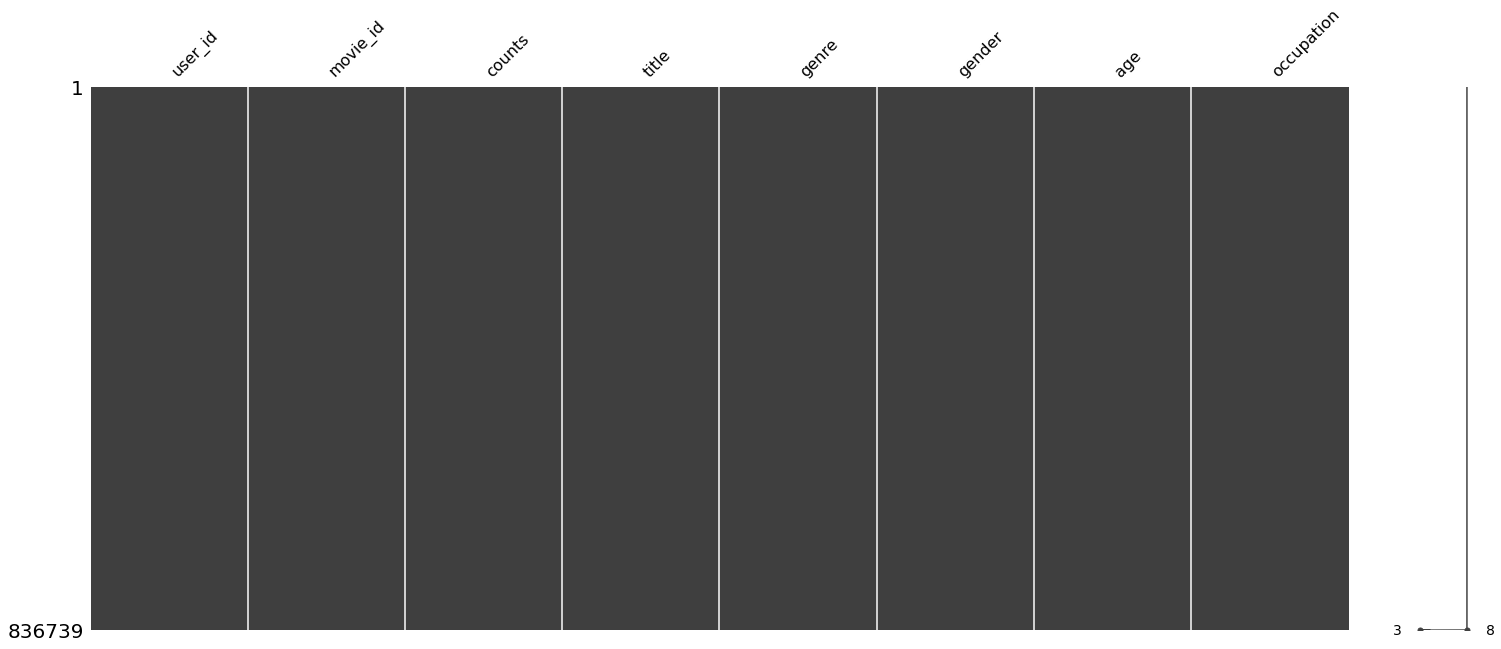

In [27]:
import missingno as msno
msno.matrix(df)
plt.show()

In [28]:
def is_emptystring(x):
    return x.eq('').any()
df.apply(lambda x:is_emptystring(x))

user_id       False
movie_id      False
counts        False
title         False
genre         False
gender        False
age           False
occupation    False
dtype: bool

In [29]:
print(df.shape)
df=df.dropna(how='any')
print(df.shape)
df

(836739, 8)
(836483, 8)


,user_id,movie_id,counts,title,genre,gender,age,occupation
0,9999.0,2571.0,5.0,"Matrix, The (1999)",Action|Sci-Fi|Thriller,F,25.0,0.0
1,9999.0,2762.0,5.0,"Sixth Sense, The (1999)",Thriller,F,25.0,0.0
2,9999.0,480.0,5.0,Jurassic Park (1993),Action|Adventure|Sci-Fi,F,25.0,0.0
3,9999.0,1580.0,5.0,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,F,25.0,0.0
4,9999.0,1.0,5.0,Forrest Gump (1994),Comedy|Romance|War,F,25.0,0.0
...,...,...,...,...,...,...,...,...
836473,2908.0,366.0,5.0,Wes Craven's New Nightmare (1994),Horror,M,18.0,2.0
836474,2908.0,2867.0,3.0,Fright Night (1985),Comedy|Horror,M,18.0,2.0
836475,2908.0,1924.0,3.0,Plan 9 from Outer Space (1958),Horror|Sci-Fi,M,18.0,2.0
836476,2908.0,3652.0,3.0,City of the Living Dead (Paura nella città dei...,Horror,M,18.0,2.0


In [30]:
# 소문자 바꾸기
df['title'] = df['title'].str.lower()
df['genre'] = df['genre'].str.lower()
df.head()

/tmp/ipykernel_87/2300224698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].str.lower()
/tmp/ipykernel_87/2300224698.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genre'] = df['genre'].str.lower()


,user_id,movie_id,counts,title,genre,gender,age,occupation
0,9999.0,2571.0,5.0,"matrix, the (1999)",action|sci-fi|thriller,F,25.0,0.0
1,9999.0,2762.0,5.0,"sixth sense, the (1999)",thriller,F,25.0,0.0
2,9999.0,480.0,5.0,jurassic park (1993),action|adventure|sci-fi,F,25.0,0.0
3,9999.0,1580.0,5.0,men in black (1997),action|adventure|comedy|sci-fi,F,25.0,0.0
4,9999.0,1.0,5.0,forrest gump (1994),comedy|romance|war,F,25.0,0.0


In [31]:
# year 추출하여 칼럼만들고, title 칼럼 정리하기
df["year"] = df["title"].str.extract(r"\((\d{4})\)")
df["title"] = df["title"].str.replace(r"\s+\(\d{4}\)", "")
df

/tmp/ipykernel_87/1458057100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = df["title"].str.extract(r"\((\d{4})\)")
/tmp/ipykernel_87/1458057100.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["title"] = df["title"].str.replace(r"\s+\(\d{4}\)", "")
/tmp/ipykernel_87/1458057100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title"] = df["title"].str.replace(r"\s+\(\d{4}\)", "")


,user_id,movie_id,counts,title,genre,gender,age,occupation,year
0,9999.0,2571.0,5.0,"matrix, the",action|sci-fi|thriller,F,25.0,0.0,1999
1,9999.0,2762.0,5.0,"sixth sense, the",thriller,F,25.0,0.0,1999
2,9999.0,480.0,5.0,jurassic park,action|adventure|sci-fi,F,25.0,0.0,1993
3,9999.0,1580.0,5.0,men in black,action|adventure|comedy|sci-fi,F,25.0,0.0,1997
4,9999.0,1.0,5.0,forrest gump,comedy|romance|war,F,25.0,0.0,1994
...,...,...,...,...,...,...,...,...,...
836473,2908.0,366.0,5.0,wes craven's new nightmare,horror,M,18.0,2.0,1994
836474,2908.0,2867.0,3.0,fright night,comedy|horror,M,18.0,2.0,1985
836475,2908.0,1924.0,3.0,plan 9 from outer space,horror|sci-fi,M,18.0,2.0,1958
836476,2908.0,3652.0,3.0,city of the living dead (paura nella città dei...,horror,M,18.0,2.0,1980


In [32]:
# genre 는 |로 split하여 원핫하고,
# gender도 one hot 해주기
df = df.join(df["genre"].str.get_dummies(sep="|"))
df = df.join(df["gender"].str.get_dummies())
df.head()

,user_id,movie_id,counts,title,genre,gender,age,occupation,year,action,...,horror,musical,mystery,romance,sci-fi,thriller,war,western,F,M
0,9999.0,2571.0,5.0,"matrix, the",action|sci-fi|thriller,F,25.0,0.0,1999,1,...,0,0,0,0,1,1,0,0,1,0
0,9999.0,2571.0,5.0,"matrix, the",action|sci-fi|thriller,F,25.0,0.0,1999,1,...,0,0,0,0,1,1,0,0,1,0
0,9999.0,2571.0,5.0,"matrix, the",action|sci-fi|thriller,F,25.0,0.0,1999,1,...,0,0,0,0,1,1,0,0,1,0
0,9999.0,2571.0,5.0,"matrix, the",action|sci-fi|thriller,F,25.0,0.0,1999,1,...,0,0,0,0,1,1,0,0,1,0
0,9999.0,2571.0,5.0,"matrix, the",action|sci-fi|thriller,F,25.0,0.0,1999,0,...,0,0,0,0,0,0,0,0,1,0


In [33]:
df = df.drop(['genre','gender'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836553 entries, 0 to 836477
Data columns (total 27 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      836553 non-null  float64
 1   movie_id     836553 non-null  float64
 2   counts       836553 non-null  float64
 3   title        836553 non-null  object 
 4   age          836553 non-null  float64
 5   occupation   836553 non-null  float64
 6   year         836553 non-null  object 
 7   action       836553 non-null  int64  
 8   adventure    836553 non-null  int64  
 9   animation    836553 non-null  int64  
 10  children's   836553 non-null  int64  
 11  comedy       836553 non-null  int64  
 12  crime        836553 non-null  int64  
 13  documentary  836553 non-null  int64  
 14  drama        836553 non-null  int64  
 15  fantasy      836553 non-null  int64  
 16  film-noir    836553 non-null  int64  
 17  horror       836553 non-null  int64  
 18  musical      836553 non-

In [34]:
# astype 정리해주기
columns_to_convert = ["user_id","movie_id","counts","age","occupation","year"]
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, downcast='integer')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836553 entries, 0 to 836477
Data columns (total 27 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      836553 non-null  int16 
 1   movie_id     836553 non-null  int16 
 2   counts       836553 non-null  int8  
 3   title        836553 non-null  object
 4   age          836553 non-null  int8  
 5   occupation   836553 non-null  int8  
 6   year         836553 non-null  int16 
 7   action       836553 non-null  int64 
 8   adventure    836553 non-null  int64 
 9   animation    836553 non-null  int64 
 10  children's   836553 non-null  int64 
 11  comedy       836553 non-null  int64 
 12  crime        836553 non-null  int64 
 13  documentary  836553 non-null  int64 
 14  drama        836553 non-null  int64 
 15  fantasy      836553 non-null  int64 
 16  film-noir    836553 non-null  int64 
 17  horror       836553 non-null  int64 
 18  musical      836553 non-null  int64 
 19  my

/tmp/ipykernel_87/1590489444.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.triu(np.ones_like(df.corr(), dtype=np.bool))


Text(0.5, 1.0, 'Correlation')

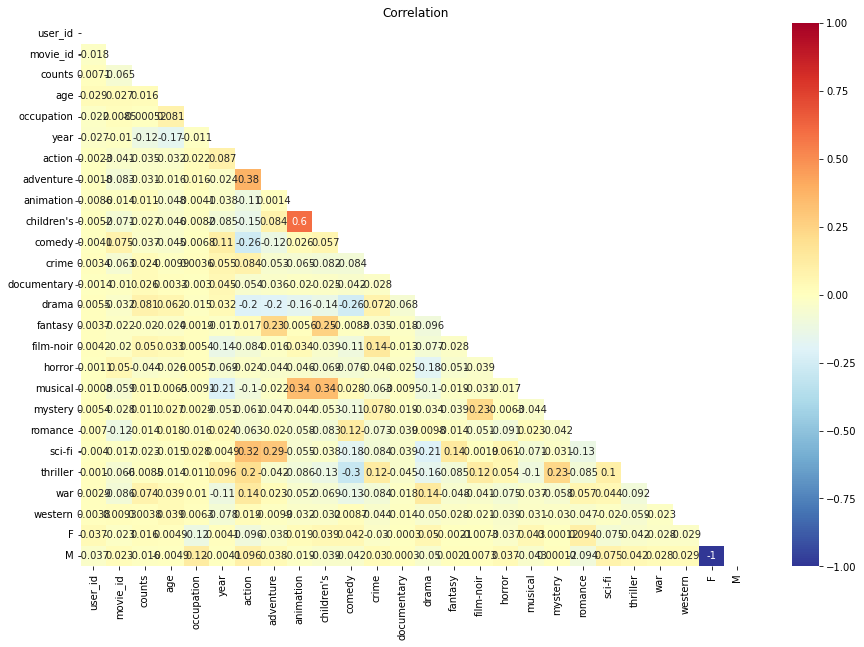

In [35]:
import seaborn as sns

np.triu(np.ones_like(df.corr()))
mask=np.triu(np.ones_like(df.corr(), dtype=np.bool))
fig,ax=plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(),mask=mask,vmin=-1,vmax=1,annot=True,cmap="RdYlBu_r",cbar=True)
ax.set_title('Correlation')

In [36]:
# 인덱싱
# 영화 이름으로 인덱스 번호를 찾거나, 
# 인덱스번호로 영화 이름을 찾아내는 코드
movie_unique = df['title'].unique()
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}
idx_to_movie = {k:v for k,v in enumerate(movie_unique)}

# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(movie_to_idx['men in black'])
print(idx_to_movie[6])

6
men in black


# 4) CSR matrix를 직접 만들어 봅시다.

In [37]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

data = np.array(df['counts'])
row_indices = np.array(df['user_id'])
col_indices = np.array(df['movie_id'])
csr_data = csr_matrix((data, (row_indices, col_indices)), dtype=int)
print(csr_data)
print(row_indices.shape,col_indices.shape)
print(csr_data.shape)

  (1, 1)	5
  (1, 48)	5
  (1, 150)	5
  (1, 260)	4
  (1, 527)	5
  (1, 531)	4
  (1, 588)	4
  (1, 594)	4
  (1, 595)	5
  (1, 608)	4
  (1, 661)	24
  (1, 720)	3
  (1, 745)	3
  (1, 783)	4
  (1, 914)	24
  (1, 919)	4
  (1, 938)	4
  (1, 1022)	5
  (1, 1028)	5
  (1, 1029)	5
  (1, 1035)	5
  (1, 1097)	4
  (1, 1193)	40
  (1, 1197)	3
  (1, 1207)	4
  :	:
  (6040, 3334)	5
  (6040, 3342)	3
  (6040, 3359)	4
  (6040, 3362)	4
  (6040, 3418)	3
  (6040, 3421)	3
  (6040, 3422)	3
  (6040, 3449)	3
  (6040, 3471)	4
  (6040, 3504)	4
  (6040, 3505)	4
  (6040, 3521)	5
  (6040, 3543)	4
  (6040, 3547)	4
  (6040, 3671)	4
  (6040, 3683)	4
  (6040, 3703)	4
  (6040, 3735)	4
  (6040, 3751)	4
  (6040, 3819)	5
  (9999, 1)	40
  (9999, 480)	40
  (9999, 1580)	40
  (9999, 2571)	40
  (9999, 2762)	40
(836553,) (836553,)
(10000, 3953)


# 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.

In [38]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, 
                                    iterations=25, dtype=np.float32)

# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/25 [00:00<?, ?it/s]

# 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

In [39]:
# 나와 men_in_black의 내적곱 = 선호도
men_in_black = movie_to_idx['men in black']
my_vector, men_in_black_vector = als_model.user_factors[9999], als_model.item_factors[men_in_black]
print("[맨인블랙에 대한 나의 선호도 :]")
np.dot(my_vector, men_in_black_vector)

[맨인블랙에 대한 나의 선호도 :]


0.06349618

In [40]:
# 다른영화들의 선호도 보기

my_movies = ['matrix, the','sixth sense, the','jurassic park','men in black','forrest gump']

for i in my_movies:
    one_pick = movie_to_idx[i]
    my_vector, one_pick_vector = als_model.user_factors[9999], als_model.item_factors[one_pick]
    print("[좋아하는 영화들에 대한 나의 선호도 :]")
    print(i,np.dot(my_vector, one_pick_vector))


[좋아하는 영화들에 대한 나의 선호도 :]
matrix, the 0.0
[좋아하는 영화들에 대한 나의 선호도 :]
sixth sense, the 0.08130585
[좋아하는 영화들에 대한 나의 선호도 :]
jurassic park 0.05692639
[좋아하는 영화들에 대한 나의 선호도 :]
men in black 0.06349618
[좋아하는 영화들에 대한 나의 선호도 :]
forrest gump 0.0015924355


### 너무 낮아서 계속 다시 학습시켰음

- factor 100, iteration 15  
matrix, the 0.0  
sixth sense, the 0.0561376  
jurassic park 0.060901392  
men in black 0.040731147  
forrest gump 0.0030437768  


- factor 100, iteration 20   
matrix, the 0.0  
sixth sense, the 0.06470841  
jurassic park 0.07271862  
men in black 0.031621397  
forrest gump 0.00979532   


- factor 200, iteration 15  
matrix, the 0.0  
sixth sense, the 0.029198505  
jurassic park 0.026114862  
men in black -0.028138861  
forrest gump 0.00044845865    


- factor 200, iteration 20  
matrix, the 0.0  
sixth sense, the 0.07286924  
jurassic park 0.035715017  
men in black -0.07784117  
forrest gump -0.005974494  

# 7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

In [41]:
# men_in_black과 비슷한 영화 15개들의 (인덱스값, 벡터값) 출력하고
# 가장 벡터값 높은순으로 sort 했음.
similar_movies = als_model.similar_items(men_in_black, N=15)
similar_movies = sorted(similar_movies,key=lambda x: x[1],reverse=True)
similar_movies

[(6, 1.0000001),
 (2278, 0.68891805),
 (1912, 0.612977),
 (555, 0.5461506),
 (474, 0.5224709),
 (47, 0.48311034),
 (2391, 0.48175406),
 (1729, 0.46478093),
 (1089, 0.4545399),
 (2353, 0.4481241),
 (493, 0.445175),
 (2058, 0.43060485),
 (163, 0.4298141),
 (1047, 0.42161363),
 (2952, 0.40414977)]

In [42]:
# 인덱스값으로 영화이름 매핑해서 불러오기

print("[맨인블랙과 비슷한 영화 Top 10]")
recommand_like_men = [idx_to_movie[i[0]] for i in similar_movies]
recommand_like_men 

[맨인블랙과 비슷한 영화 Top 10]


['men in black',
 'wrongfully accused',
 'cimarron',
 'man with the golden gun, the',
 "midsummer night's dream, a",
 'run lola run (lola rennt)',
 'affliction',
 'butcher boy, the',
 'jerry maguire',
 'van, the',
 'labyrinth',
 "we're no angels",
 'godfather: part ii, the',
 'love bug, the',
 'thieves (voleurs, les)']

In [43]:
# 몇 번 더 반복해서 확인하기 위해 위의 코드를 함수로 만들고 확인
def get_similar_movie(movie_title: str):
    movie_id = movie_to_idx[movie_title]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [44]:
print("[쥬라기공원과 비슷한 영화 Top 10]")
get_similar_movie('jurassic park')

[쥬라기공원과 비슷한 영화 Top 10]


['jurassic park',
 'mask, the',
 '12 angry men',
 'mortal thoughts',
 "porky's ii: the next day",
 'goodfellas',
 'morning after, the',
 'inferno',
 'twelve monkeys',
 'rescuers, the']

In [45]:
print("[포레스트검프와 비슷한 영화 Top 10]")
get_similar_movie('forrest gump')

[포레스트검프와 비슷한 영화 Top 10]


['forrest gump',
 'mars attacks!',
 'hoosiers',
 'getaway, the',
 'father of the bride',
 'lady and the tramp',
 'bowfinger',
 'killing fields, the',
 'lethal weapon 2',
 'four weddings and a funeral']

# 8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

In [46]:
movie_recommended = als_model.recommend(9999, csr_data, N=10, filter_already_liked_items=True)
movie_recommended

[(589, 0.92879605),
 (3114, 0.73242456),
 (2916, 0.59740466),
 (457, 0.56634617),
 (356, 0.5623522),
 (2628, 0.55020744),
 (34, 0.47701815),
 (1265, 0.44424218),
 (2858, 0.40075994),
 (2355, 0.37935287)]

In [47]:
print("[내가 좋아할만한 영화 Top 10]")
[idx_to_movie[i[0]] for i in movie_recommended]

[내가 좋아할만한 영화 Top 10]


["bram stoker's dracula",
 'tetsuo ii: body hammer',
 'perfect blue',
 'city of lost children, the',
 'tron',
 'six-string samurai',
 'close shave, a',
 "nobody's fool",
 'hush',
 'apple dumpling gang, the']

In [58]:
movie_recommended_ex = als_model.explain(9999, csr_data, itemid= movie_to_idx["six-string samurai"])
print("six-string samurai 추천에 기여한 영화들과 기여도:")
print([(idx_to_movie[i[0]], i[1]) for i in movie_recommended_ex[1]])
print("six-string samurai 영화에 대한 나의 선호도 예측치")
samurai = movie_to_idx['six-string samurai']
my_vector, samurai_vector = als_model.user_factors[9999], als_model.item_factors[samurai]
np.dot(my_vector, samurai_vector)

six-string samurai 추천에 기여한 영화들과 기여도:
[('jungle fever', 0.3258533748999353), ('cosi', 0.24121395130698897), ('perfect candidate, a', 0.08562332171799777), ("one flew over the cuckoo's nest", -0.045369558759751454), ('batman', -0.07171741220065744)]
six-string samurai 영화에 대한 나의 선호도 예측치


0.55020744

# 회고

아이디어  
- 이것으로 예전에 하던 순슐랭 맛집 리스트를 데이터로 옮겨서 추천시스템을 만들 수 있겠다... 후후후
- 리테일 업계에서 추천을 잘 활용하면 아주 좋은 기회가 될 것 같은데, lms에서 본 것 처럼 뉴스같은 경우는 너무 편향된 정보만 볼 수 있을 듯 하다. 
- 소개팅 어플에도 가능할 것 같았다.
- 내맘을 알아주는 AI라는 생각이 들어야만 personalized 된 AI 라고 생각하는데, 그런 의미에서 추천시스템은 그야말로 최고가 아닐까..


학습정리
- 단순히 행렬의 곱셈법칙이었는데, 중간에 k가 들어가면서 잠재요인을 분석할 수 있는 컨셉이 신박했다.
- MF는 시간이 오래걸리니 sparse 줄여주는 CSR matrix를 ALS에 넣는게 훨씬 효율적이었다.
- 영화가 거의 90년대 이전 데이터라서,, 추천을 해줘도 와닿지가 않았다. 하지만 찾아보니 재미있겠는데? 하며 흥미로워하는 나를 발견했다. 추천받은 10개 중 4개는 한번 보고싶기도 했다. 아주 유용하고 재미있는 프로젝트였다.

참고자료  
- 이번에는 구입한 통계관련 책을 보면서 전처리를 해봤다. 이번 익스와는 관계가 없지만 데이터 분포의 중요성과 normalization에 대해 많이 배운 것 같다. 
- CSR, MF, ALS의 개념을 잡게 묻고 또 물었는데,, 어린아이에게 설명해주듯이 해달라고 떼써도 친절하게 답해준 chatGPT에게 고맙다.  

Answer (by.chat GPT)

MF (Matrix Factorization) and ALS (Alternating Least Squares) are both collaborative filtering techniques used in recommendation systems. The main difference between the two is how they approach the problem of matrix factorization:

MF:  
- Performs matrix factorization directly on the user-item nteraction matrix
- Can be a time-consuming process for large datasets

ALS:  
- Alternates between fixing one matrix (either user or item matrix) and solving for the other
- Faster than direct matrix factorization, especially for sparse datasets
- Can also handle implicit feedback (e.g. user-item interaction) in addition to explicit feedback (e.g. user ratings).

루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. CSR matrix가 정상적으로 만들어졌다.
- 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.

2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.
- 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.

3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.
- MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도를 측정하고 의미를 분석해보았다.